In [20]:
# Bibliotheken importieren
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor  # Import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor  # Import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor  # Corrected import for SGDRegressor

In [21]:
url = 'nyc_taxi_fare_cleaned.csv'
df = pd.read_csv(url, nrows=100_000)  # Beschränkung wegen Größe

In [22]:
# 🧹 Datensäuberung
df = df.dropna()
df = df[(df['fare_amount'] > 0) & (df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]


In [23]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Erdradius in km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df["distance_km"] = haversine(
    df["pickup_latitude"], df["pickup_longitude"],
    df["dropoff_latitude"], df["dropoff_longitude"]
)

In [24]:
# Add pickup_datetime as a feature
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])  # Ensure it's in datetime format
df["pickup_hour"] = df["pickup_datetime"].dt.hour  # Extract the hour
df["pickup_day_of_week"] = df["pickup_datetime"].dt.dayofweek  # Extract the day of the week

# Update input variables
X = df[["distance_km", "passenger_count", "pickup_hour", "pickup_day_of_week"]]
y = df["fare_amount"]

In [25]:
# 3.1  Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# 3.2 Modellvergleich mit sklearn
models = {
     # Regression models
    "Linear Regression": LinearRegression(),
    "Decision Tree (Regressor)": DecisionTreeRegressor(random_state=42),
    "Random Forest (Regressor)": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Neural Network (MLP Regressor)": MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "K-Nearest Neighbors (Regressor)": KNeighborsRegressor(),  # Corrected to KNeighborsRegressor
    "SGD Regressor": SGDRegressor(random_state=42),  # Corrected to SGDRegressor
    }

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)  # Compute MSE
    rmse = mse ** 0.5  # Compute RMSE
    results[name] = rmse
    print(f"{name}: RMSE = {rmse:.2f}")

sorted_results = sorted(results.items(), key=lambda x: x[1])

print("\nSortierte Ergebnisse (nach RMSE):")
for name, rmse in sorted_results:
    print(f"{name}: RMSE = {rmse:.2f}")

Linear Regression: RMSE = 10.56
Decision Tree (Regressor): RMSE = 7.77
Decision Tree (Regressor): RMSE = 7.77
Random Forest (Regressor): RMSE = 6.38
Random Forest (Regressor): RMSE = 6.38
Gradient Boosting: RMSE = 6.11
Gradient Boosting: RMSE = 6.11
Neural Network (MLP Regressor): RMSE = 6.23
Neural Network (MLP Regressor): RMSE = 6.23
K-Nearest Neighbors (Regressor): RMSE = 6.50
SGD Regressor: RMSE = 4371405765685.21

Sortierte Ergebnisse (nach RMSE):
Gradient Boosting: RMSE = 6.11
Neural Network (MLP Regressor): RMSE = 6.23
Random Forest (Regressor): RMSE = 6.38
K-Nearest Neighbors (Regressor): RMSE = 6.50
Decision Tree (Regressor): RMSE = 7.77
Linear Regression: RMSE = 10.56
SGD Regressor: RMSE = 4371405765685.21
K-Nearest Neighbors (Regressor): RMSE = 6.50
SGD Regressor: RMSE = 4371405765685.21

Sortierte Ergebnisse (nach RMSE):
Gradient Boosting: RMSE = 6.11
Neural Network (MLP Regressor): RMSE = 6.23
Random Forest (Regressor): RMSE = 6.38
K-Nearest Neighbors (Regressor): RMSE = 6

# 3.2 Erklärung (z. B. für Gradient Boosting):
Gradient Boosting wurde gewählt, weil es komplexe, nicht-lineare Zusammenhänge gut modellieren kann 
und oft eine höhere Genauigkeit liefert als einfachere Modelle wie lineare Regression oder Entscheidungsbäume. 
Es kombiniert viele schwache Modelle zu einem starken und ist dadurch besonders gut geeignet, um feinere Muster 
in den Daten zu erkennen. Für strukturierte Daten wie in diesem Datensatz ist es eine sehr leistungsfähige Wahl.



Beispielhafte Vorhersagen:
   Tatsächlich  Vorhersage
0          6.5    5.084524
1          6.1    5.920764
2          5.3    7.378808
3         10.1   11.162016
4         11.3    8.929429
5          9.7   11.430896
6          5.7    6.783107
7         17.3   21.636364
8          8.5   11.067636
9          4.9    5.328940


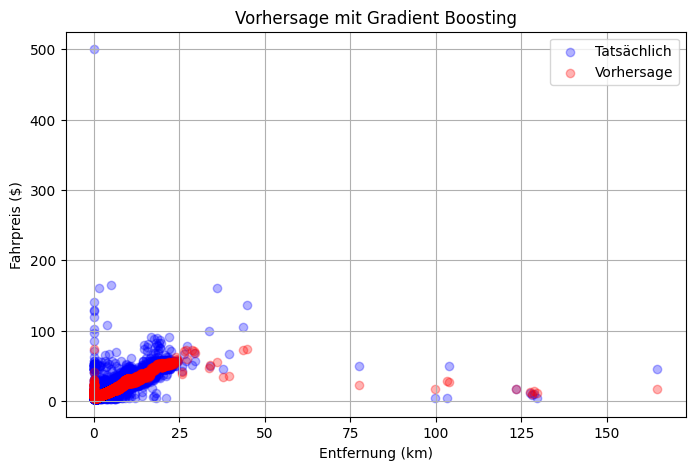

In [27]:
# 3.3 Vorhersagen visualisieren (bspw. für bestes Modell)
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)

vergleich = pd.DataFrame({
    "Tatsächlich": y_test.values[:10],
    "Vorhersage": y_pred[:10]
})
print("\nBeispielhafte Vorhersagen:")
print(vergleich)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_test["distance_km"], y_test, alpha=0.3, label="Tatsächlich", color="blue")
plt.scatter(X_test["distance_km"], y_pred, alpha=0.3, label="Vorhersage", color="red")
plt.xlabel("Entfernung (km)")
plt.ylabel("Fahrpreis ($)")
plt.title(f"Vorhersage mit {best_model_name}")
plt.legend()
plt.grid(True)
plt.show()


# 3.3 Erkenntnisse (Zusammenfassung):
Das Modell Gradient Boosting erzielte die besten Ergebnisse mit einem RMSE von X. Die Vorhersagen sind im mittleren Bereich stabil, zeigen jedoch Schwächen bei extrem kurzen oder langen Fahrten. Dies könnte auf fehlerhafte Daten oder Spezialfälle zurückzuführen sein. Die Entfernung bleibt der wichtigste Prädiktor für den Fahrpreis, zusätzliche Features könnten weitere Verbesserungen bringen.